In [9]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/scratch/anissa.el/macro_micro_niches/macro_micro_niches2022/TMENS_analysis/notebooks/keren_building_blocks_analysis'

In [10]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from src.CellAbundance import CellAbundance, join_abundance_matrices, generate_abundance_matrix
from src.utils.archetypes import ArchetypalAnalysis
from src.utils.visualization import plot_scatter_pca, plot_3Dscatter_pca, archetypes_bar_plot, archetype_simple_plot
from src.utils.equations import arch2color, alfa2rgb, scale, color_mapper

### 3D Archetypes - All tumors - 4 archetypes

In [11]:
CELL_TYPES = ['CD8-T', 'Other immune', 'DC / Mono', 'CD3-T', 'B', 'NK', 'Keratin-positive tumor', 'Tumor', 
              'CD4-T', 'Mesenchymal-like', 'Macrophages', 'Endothelial', 'Tregs', 'Unidentified', 'DC', 'Mono / Neu', 
              'Neutrophils']
patient_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
N_SITE = 100
RADIUS = 25
RANDOM_SEED =1022
ROOT_DATA_PATH = "../../data/cell_positions_data"#"/srv/mfs/hausserlab/fabio/output/cell_positions_data" #"../../../../fabio/output/cell_positions_data"
METHOD = "gaussian"

gauss_ca_list = generate_abundance_matrix(CELL_TYPES, patient_ids, N_SITE, RADIUS, method=METHOD,random_seed=RANDOM_SEED,snr=3,center_sites_cells=False,root=ROOT_DATA_PATH)
sites, patients_ids,sites_ids, _ = join_abundance_matrices(gauss_ca_list)

pca_3d = PCA()
pc3d = pca_3d.fit_transform(sites)

In [4]:
n_archs = list(range(2, 6))

lst_exp_var = []
for n_arch in n_archs:
    AA = ArchetypalAnalysis(n_archetypes = n_arch, 
                        tolerance = 0.001, 
                        max_iter = 200, 
                            
                        random_state = 0, 
                        C = 0.0001, 
                        initialize = 'random',
                        redundancy_try = 30)
    AA.fit(pc3d[:, :3])
    lst_exp_var.append(AA.explained_variance_)

plt.plot(n_archs, lst_exp_var, '-o')
plt.ylim(0, 1)
plt.show()

KeyboardInterrupt: 

In [12]:
AA_3D = ArchetypalAnalysis(n_archetypes = 4, 
                        tolerance = 0.001, 
                        max_iter = 200, 
                        random_state = 0, 
                        C = 0.0001, 
                        initialize = 'random',
                        redundancy_try = 30)
AA_3D.fit_transform(pc3d[:, :3])

array([[ 8.36960480e-04, -2.05139738e-04,  5.13431956e-04],
       [ 6.22451888e-04,  1.79993309e-04,  4.66145708e-04],
       [-5.45279156e-05, -1.05861330e-04,  5.32484013e-04],
       ...,
       [-1.11045895e-03, -8.26919234e-04,  1.67422287e-04],
       [-3.43905627e-03, -1.31344254e-03,  8.50245620e-05],
       [-2.79474995e-03, -9.07546280e-04, -2.04928635e-04]])

In [6]:
AA_3D.alfa.T.shape

(4000, 4)

### Visualization  and interpretation of archetypes

In [7]:
def round2one(v):
    return v if v <= 1.0 else 1.0
color_map = np.array([[255, 0, 223],[255,0,0],[70,203,236],[0,0,0]]).T #np.array([[255, 0, 0], [0, 153, 51], [0, 0, 255], [255, 255, 0]]).T
sites_archetype = [np.array([round2one(x) for x in color_mapper(color_map, c)/255]) for c in AA_3D.alfa.T]
p = np.array(sites_archetype)
p[p > 1]

array([], dtype=float64)

<IPython.core.display.Javascript object>


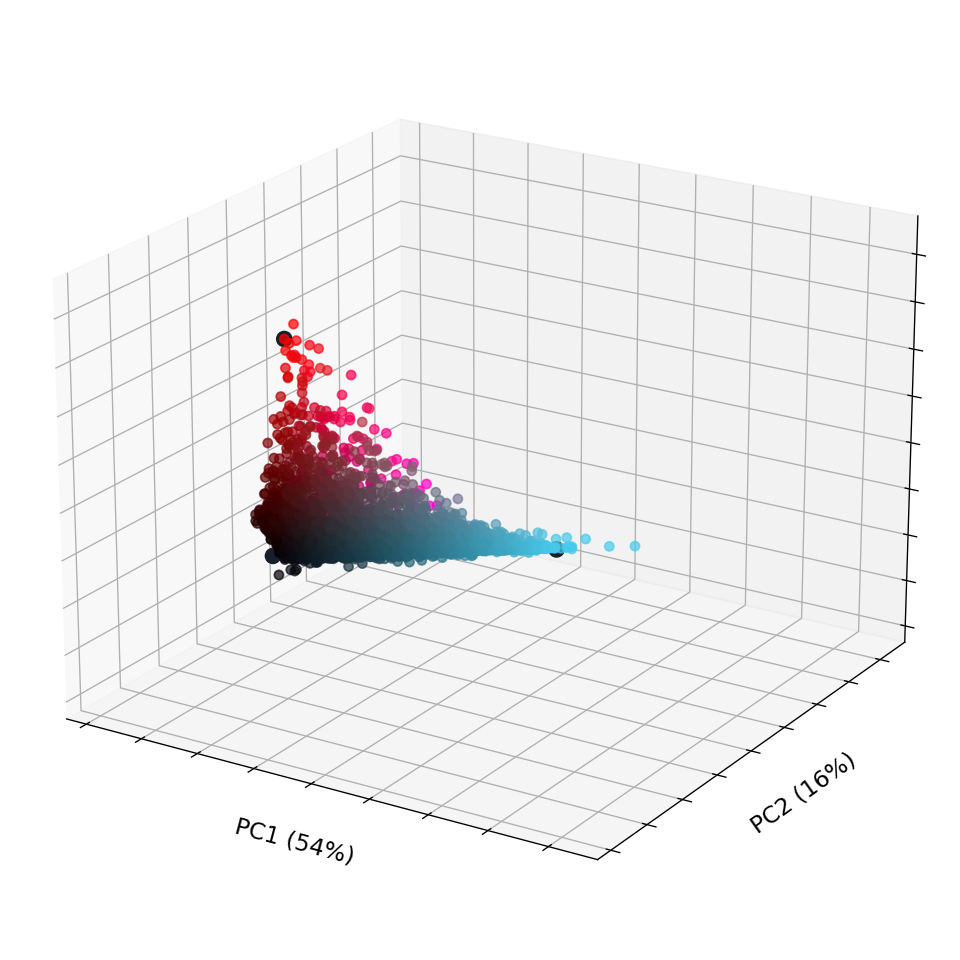

In [8]:
%matplotlib notebook
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
font = {'size'   : 14}
matplotlib.rc('font', **font)
pc3d[:, 4]= patients_ids
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=(0, 0, 1, 1), elev=21, azim=-58)

minimum = np.amin(pc3d[:, 0:3])#, maximum = _calculate_pca_max_min(principal_components[:, 0:3])
maximum = np.amax(pc3d[:, 0:3])
evr = pca_3d.explained_variance_ratio_

#col= np.where(pc3d[:, 4] ==17,"b",(0.1, 0.2, 0.5, 0.05))
ax.scatter(pc3d[:, 0],pc3d[:, 1],pc3d[:, 2],alpha=0.7,c=p,s=30)#,alpha=al,markerfacecolor="None",markeredgecolor="blue"
ax.scatter(AA_3D.archetypes[0, :],AA_3D.archetypes[1, :],AA_3D.archetypes[2, :],c="#17202A",alpha=1,s=80)

### Axes settings
ax.set_xlim(minimum, maximum)
ax.set_ylim(minimum, maximum)
ax.set_zlim(minimum, maximum)   
ax.set_xlabel("PC1 ({}%)".format(int(round(evr[0] * 100)))) #("PC1 ({:.2f}% Exp. Var.)".format(evr[0] * 100))
ax.set_ylabel("PC2 ({}%)".format(int(round(evr[1] * 100)))) #("PC2 ({:.2f}% Exp. Var.)".format(evr[1] * 100))
ax.set_zlabel("PC3 ({}%)".format(int(round(evr[2] * 100)))) #("PC3 ({:.2f}% Exp. Var.)".format(evr[2] * 100))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

<IPython.core.display.Javascript object>


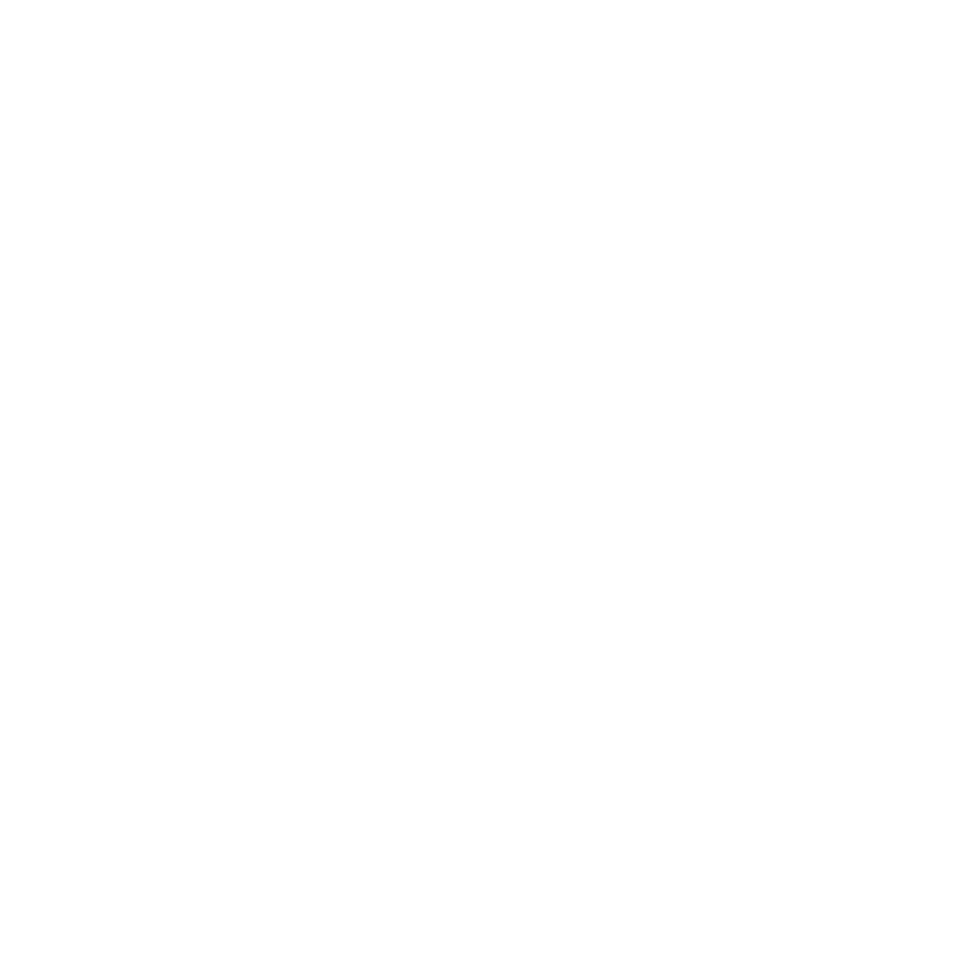

In [23]:
%matplotlib notebook
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
font = {'size'   : 14}
matplotlib.rc('font', **font)
pc3d[:, 4]= patients_ids
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=(0, 0, 1, 1), elev=21, azim=-58)

minimum = np.amin(pc3d[:, 0:3])#, maximum = _calculate_pca_max_min(principal_components[:, 0:3])
maximum = np.amax(pc3d[:, 0:3])
evr = pca_3d.explained_variance_ratio_
#FIXME add groups of sites(per patient) by layer, other patients being first plotted
#colors = patients_ids[]#189200 
## COlor 3 patients 
# red: #FF4500 patient35
# green: #41A317 patent 4
# gold yellow: #FFDF00 28
# light transparent blue: #B0CFDE1A ## 3,40,39

#col = np.where(pc3d[:, 4] ==5,"#FF4500",np.where(pc3d[:, 4] ==15,"#41A317",np.where(pc3d[:, 4] ==17,"#FFDF00","#B0CFDE1A")))#np.where(x<1,'k',np.where(y<5,'b','r'))

col = np.where(pc3d[:, 4] ==35,"#FF4500",np.where(pc3d[:, 4] ==4,"#41A317",np.where(pc3d[:, 4] ==28,"#FFDF00","#cce2fc")))#np.where(x<1,'k',np.where(y<5,'b','r'))

#col= np.where(pc3d[:, 4] ==17,"b",(0.1, 0.2, 0.5, 0.05))
patients_cols = {28:"#FFDF00",35:"#FF4500",4:"#41A317"}
col = "#cce2fc"
ax.scatter(pc3d[:, 0],pc3d[:, 1],pc3d[:, 2],alpha=0.1,facecolors=col,s=30)
for p in patients_cols.keys():
    pc3d_patient=pc3d[pc3d[:, 4]==p]
    ax.scatter(pc3d_patient[:, 0],pc3d_patient[:, 1],pc3d_patient[:, 2],alpha=0.7,c=patients_cols[p],s=30)
    
    
#col2 = np.where(pc3d[:, 4] ==35,"#FF4500",np.where(pc3d[:, 4] ==4,"#41A317",np.where(pc3d[:, 4] ==28,"#FFDF00",)))
#ax.scatter(pc3d[:, 0],pc3d[:, 1],pc3d[:, 2],alpha=0.7,c=col2,s=30)#,alpha=al,markerfacecolor="None",markeredgecolor="blue"
ax.scatter(AA_3D.archetypes[0, :],AA_3D.archetypes[1, :],AA_3D.archetypes[2, :],c="#17202A",alpha=1,s=80)

### Axes settings
ax.set_xlim(minimum, maximum)
ax.set_ylim(minimum, maximum)
ax.set_zlim(minimum, maximum)
ax.set_xlabel("PC1 ({}%)".format(int(round(evr[0] * 100))))
ax.set_ylabel("PC2 ({}%)".format(int(round(evr[1] * 100))))
ax.set_zlabel("PC3 ({}%)".format(int(round(evr[2] * 100))))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

0.81% Total Exp. Var.


<IPython.core.display.Javascript object>


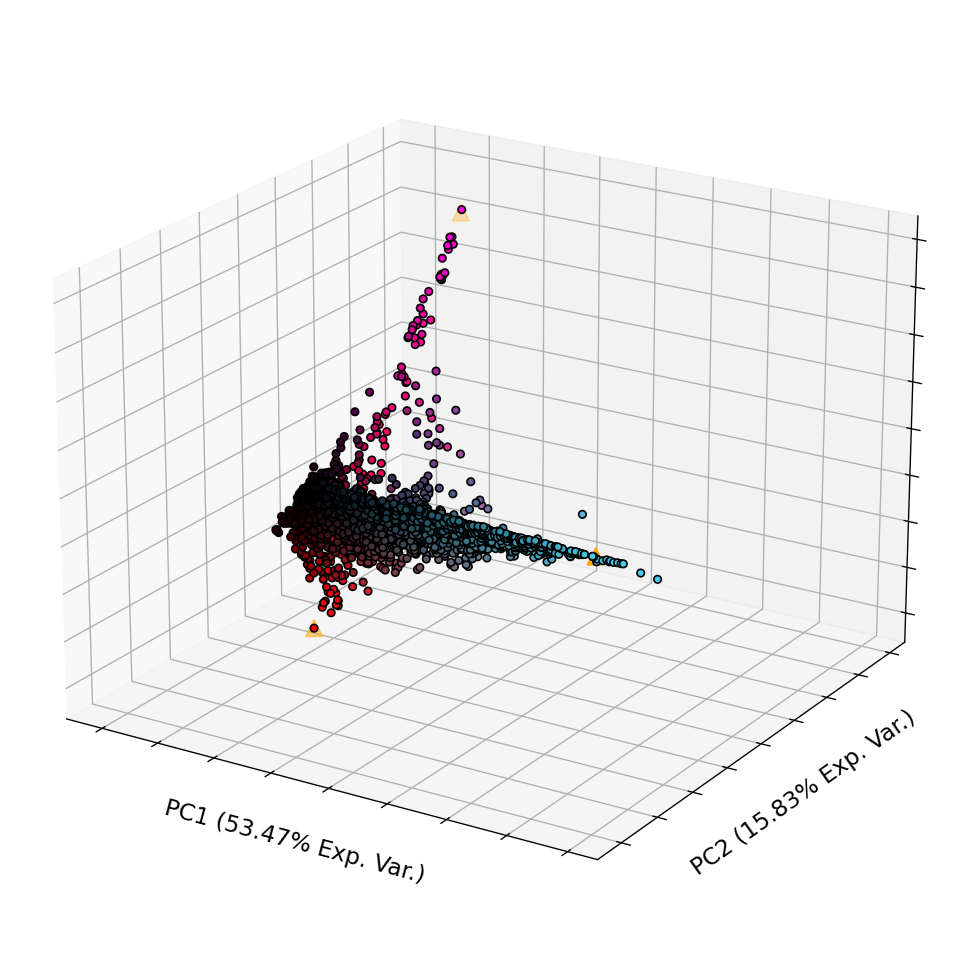

In [24]:
%matplotlib notebook
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
plt=plot_3Dscatter_pca(pc3d, pca_3d.explained_variance_ratio_, labels=sites_archetype, archetypes=AA_3D.archetypes);
#plt.savefig("/srv/mfs/hausserlab/anissa.el/figs/plot_pca_gaussian25.svg")

<IPython.core.display.Javascript object>


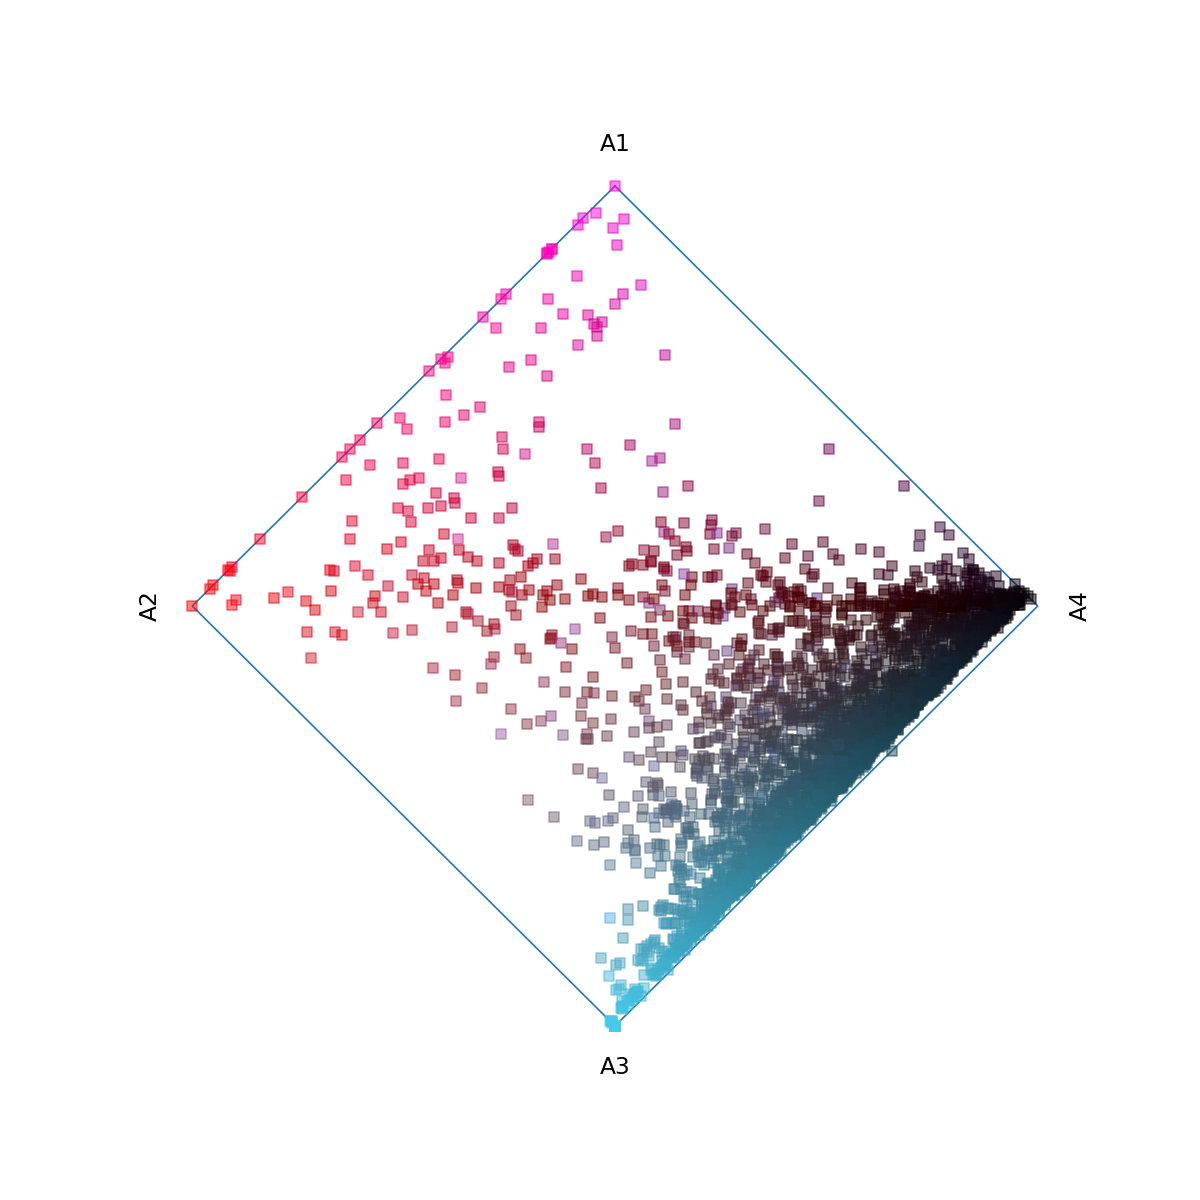

In [25]:
AA_3D.plot_simplex(AA_3D.alfa, plot_args={'c': sites_archetype})

In [26]:
n_comp = 3
res = np.dot(AA_3D.archetypes.T, pca_3d.components_[:n_comp,:])+np.mean(sites, axis=0)
print(res.shape)
#pd.DataFrame(res).to_csv("/srv/mfs/hausserlab/anissa.el/ImmuneStates/wagner_analysis/data/archetypes_building_blocks_17cells_space.csv")

(4, 17)


<IPython.core.display.Javascript object>


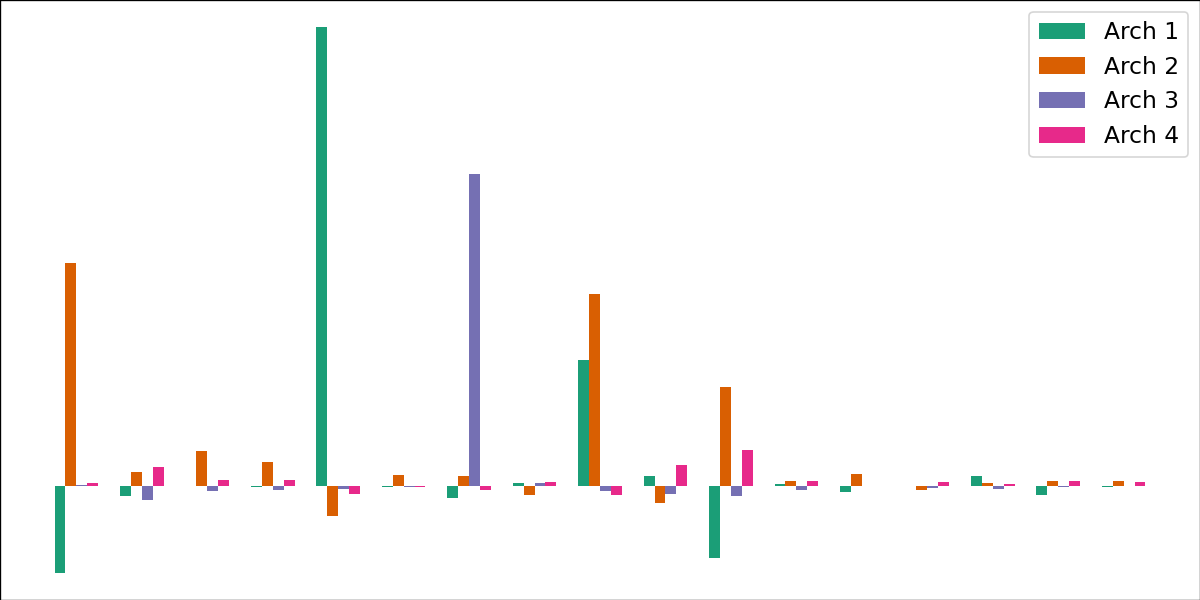

In [27]:
#FIXME negative values for density !!!
RADIUS = 25
archetype_colors = [[255/255, 0., 223/255],[255/255,0.,0.],[70/255,203/255,236/255],[0.,0.,0.]]#[[1., 0., 0.], [0. , 0.6, 0.2], [0., 0., 1.], [1.0, 1.0, 0.]]
archetypes_bar_plot(res, CELL_TYPES,None, y_axis = 'density', radius = RADIUS,path_fig="/scratch/anissa.el/figs/fig2/test.svg");#(res, CELL_TYPES, archetype_colors, y_axis = 'density', radius = RADIUS,path_fig="/scratch/anissa.el/figs/fig2/test.svg")#"/scratch/anissa.el/figs/fig2/barplotTMENS.svg"

<IPython.core.display.Javascript object>


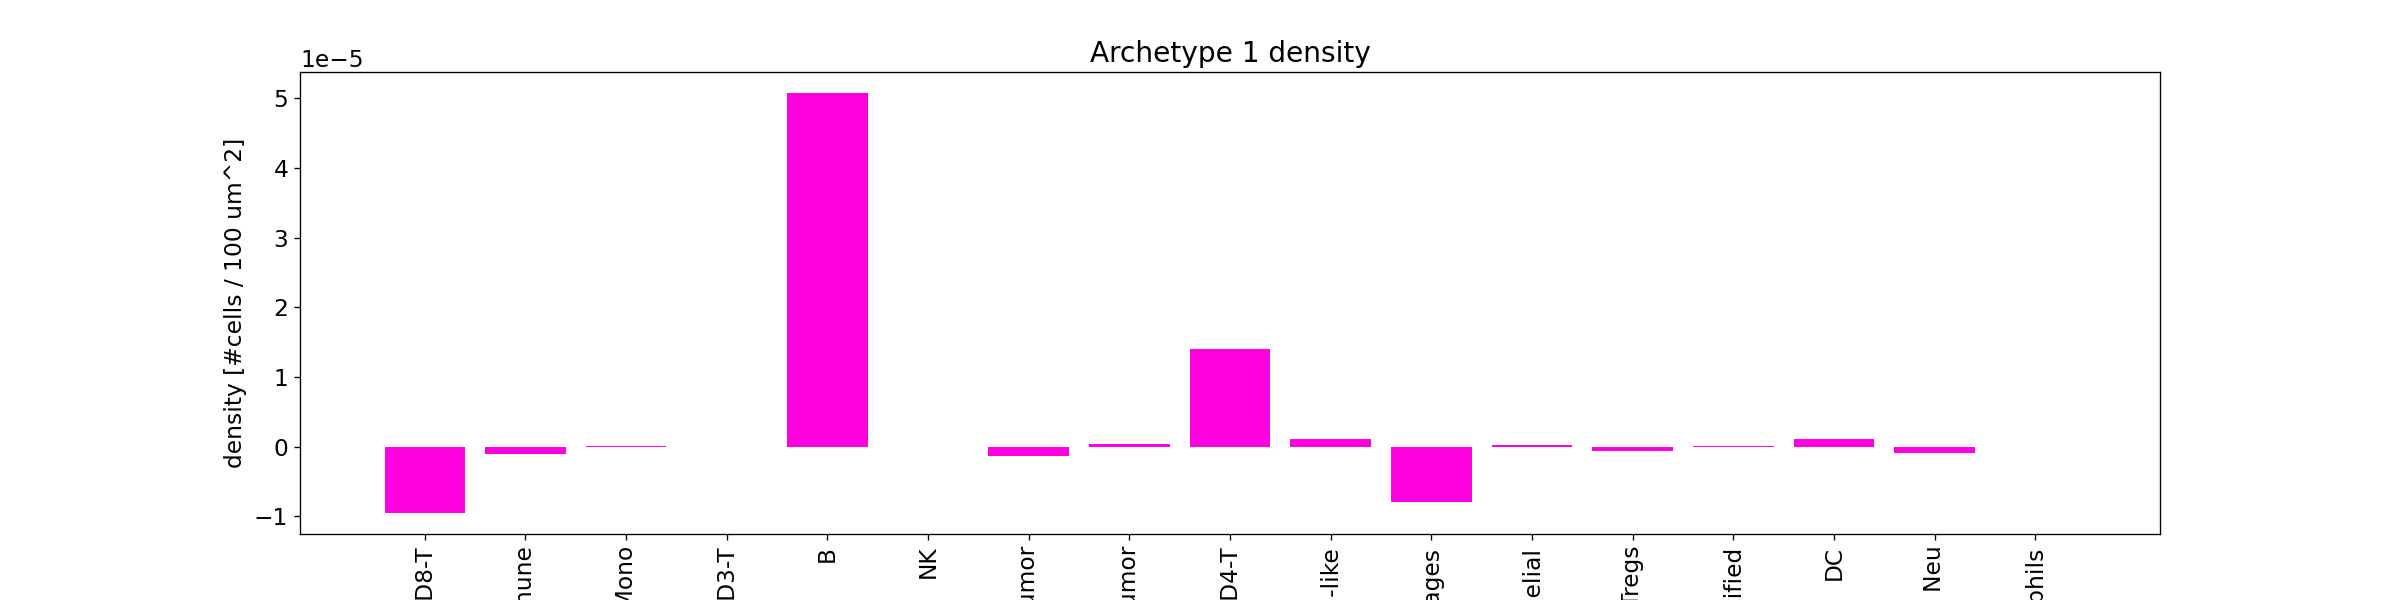

<IPython.core.display.Javascript object>


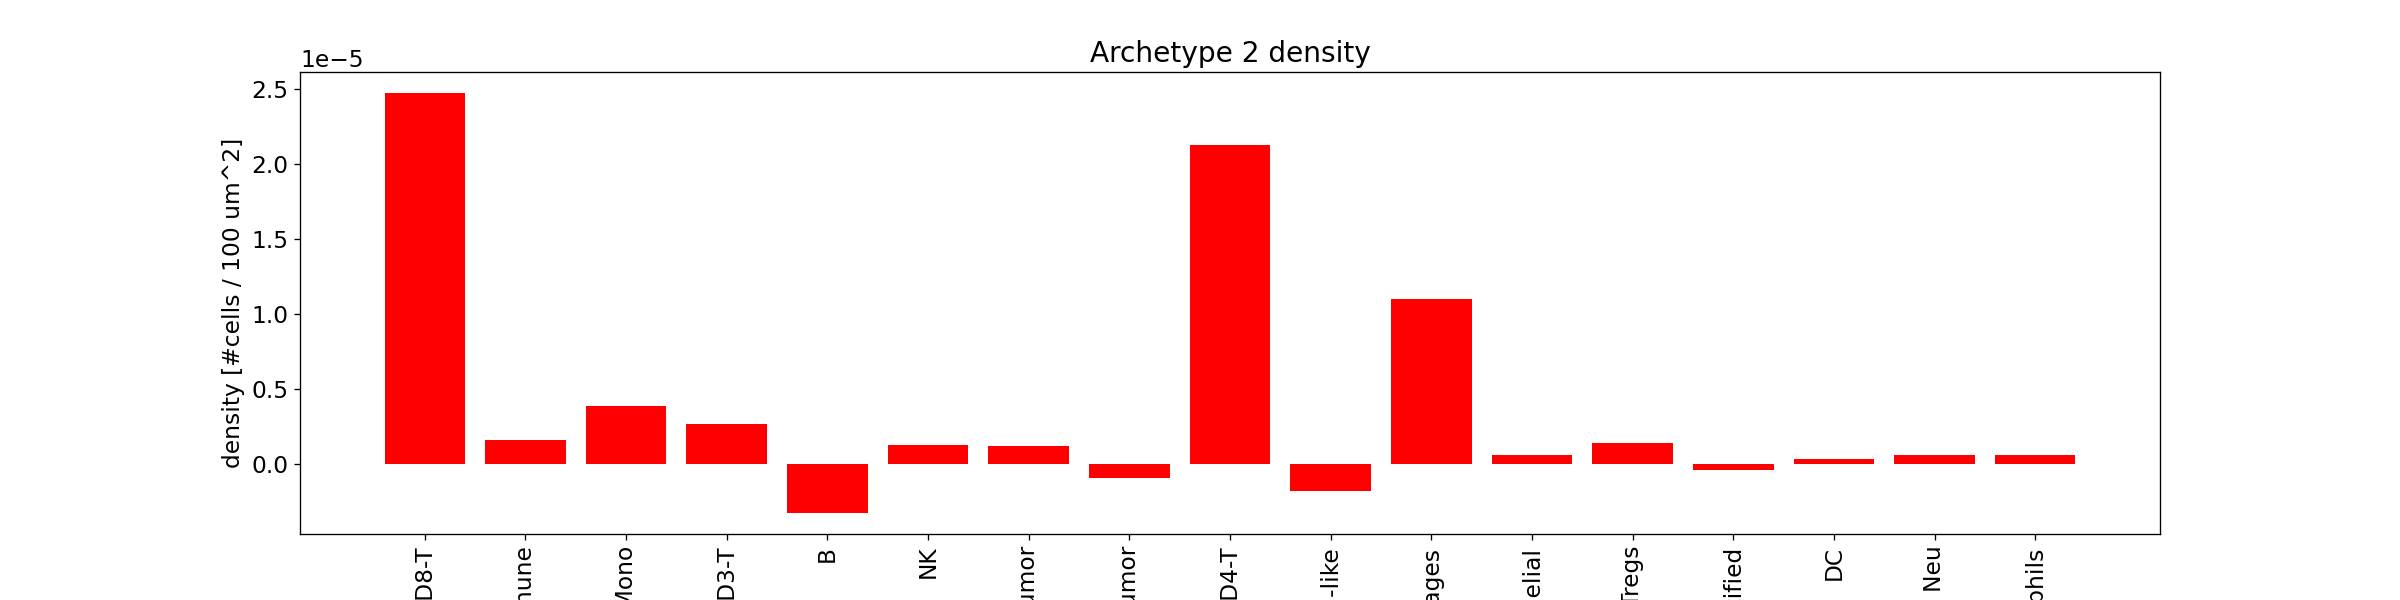

<IPython.core.display.Javascript object>


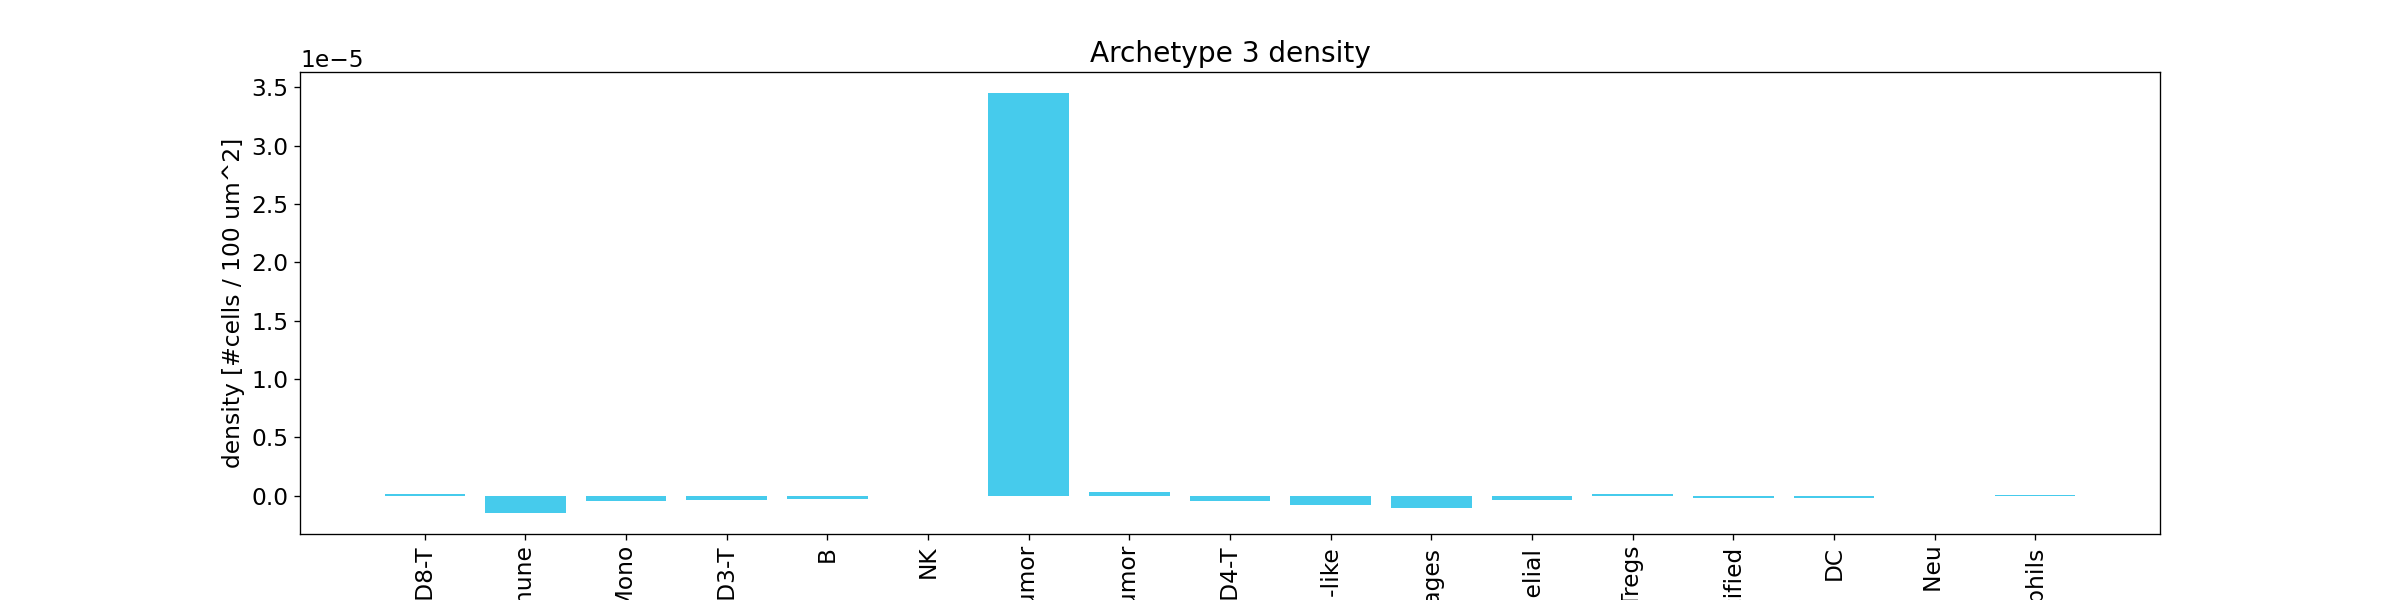

<IPython.core.display.Javascript object>


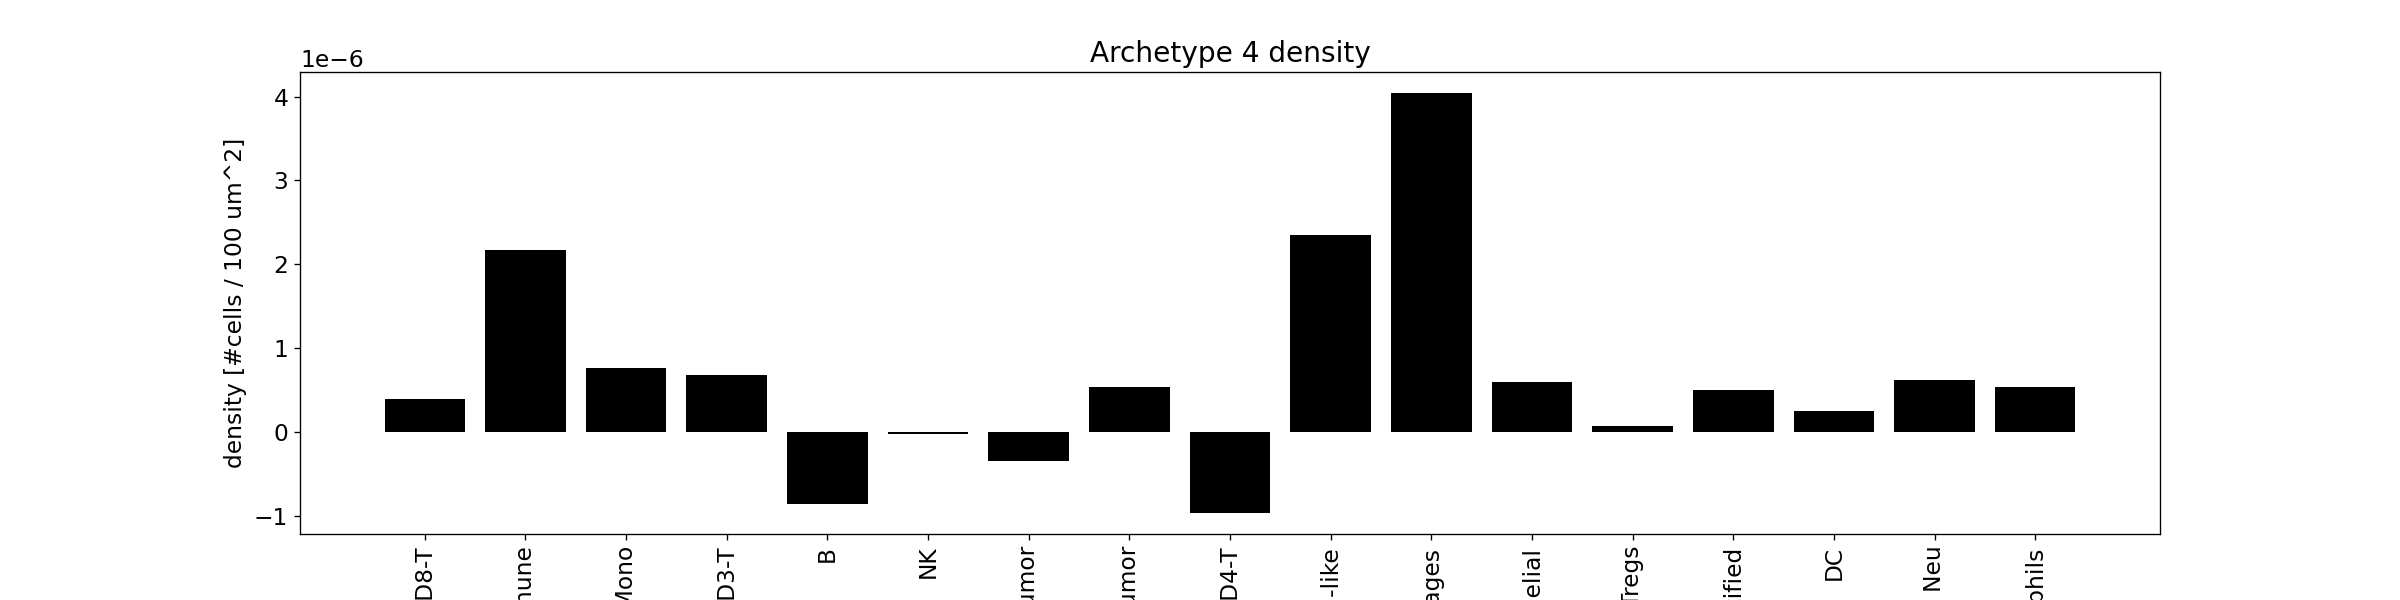

In [16]:
for a in range(4):
    archetype_simple_plot(res[a], a, archetype_colors, CELL_TYPES, y_axis='density')

### Export data from PCA and Archetype analysis

In [28]:
import pickle
with open("../../output/pca_3d_gaussian", "wb") as f:
    pickle.dump(pca_3d, f)

with open("../../output/AA_3D_gaussian", "wb") as f:
    pickle.dump(AA_3D, f)